# Simulation of Heterogeneous Denoising Methodologies

In this notebook we compare two variance-constrained empirical Bayes denoising methods on a simulated data set, that is comparing marginal variance constraints and conditional variance constraints, and we create Figure 5.1 from the arxiv version of the paper.

In [2]:
from npeb.GLMixture import *
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import scipy.stats as stats
from scipy.stats import norm

## Set up data

We sample the latent variables $\Theta_1,\ldots,\Theta_n$ come from standard Gaussian distribution $G=\mathcal{N}(0,1)$ and we sample the latent variances $\sigma_1^2,\ldots, \sigma_n^2$ from a two-point distribution where they equal 0.5 or 8 with equal probability. Then, we sample the observations from a Gaussian likelihood with mean $\theta_i$ and variance $\sigma_i^2$ for each $i=1,\ldots, n$.

Text(0.5, 1.0, '$Z$')

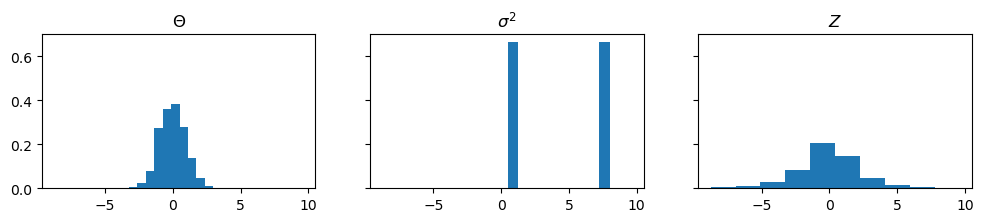

In [3]:
np.random.seed(22222)

n = 1500
var1, var2 = 0.5, 8.
xlim = 7.

Theta = np.random.normal(0,1,size=(n,1))
Sigma2 = var1 + (var2 - var1)*np.random.randint(0,2,size=(n,1))
Z = np.random.normal(Theta,np.sqrt(Sigma2),size=(n,1))

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,2))

ax[0].hist(Theta, density=True)
ax[0].set_title('$\\Theta$')

ax[1].hist(Sigma2, density=True)
ax[1].set_title('$\sigma^2$')

ax[2].hist(Z, density=True)
ax[2].set_title('$Z$')

## Compute denoisers

Next, we compute the three empirical Bayes denoisers of interest for the data above, with the help of the `npeb` package.

### (Unconstrained) empirical Bayes

In [4]:
eb_model = GLMixture(prec_type='diagonal')
prec = 1./Sigma2
eb_model.fit(Z, prec)
eb = eb_model.posterior_mean(Z, prec)

Selecting all data points as atoms: done.
Computing kernel matrix: done.
Solving for discretized NPMLE: done.


### Empirical marginal variance-constrained Bayes denoiser

In [5]:
eb_mean = np.mean(eb)
M_hat = np.var(eb)
at, wt = eb_model.get_params()
at = at.ravel()
mu_hat = np.sum(at * wt)
A_hat = np.sum(np.power(at - mu_hat,2)*wt)
transport_hat = np.sqrt(A_hat/M_hat)
eb_mcb = transport_hat*(eb - eb_mean) + mu_hat

### Empirical conditional variance-constrained Bayes denoiser

In [17]:
eb_ccb = np.zeros_like(eb)
eb_ccb[Sigma2 == var1]
at, wt = eb_model.get_params()

for var in [var1, var2]:
    
    eb_mean = np.mean(eb[Sigma2 == var])
    M_hat = np.var(eb[Sigma2 == var])
    at = at.ravel()
    mu_hat = np.sum(at * wt)
    A_hat = np.sum(np.power(at - mu_hat,2) * wt)
    transport_hat = np.sqrt(A_hat/M_hat)
    eb_ccb[Sigma2 == var] = transport_hat*(eb[Sigma2 == var] - eb_mean) + mu_hat

### Plotting

Lastly, we plot the observations and the three denoising methods of interest at the oracle level, along with the stratified versions of these plots corresponding to the observations with low and high variance.

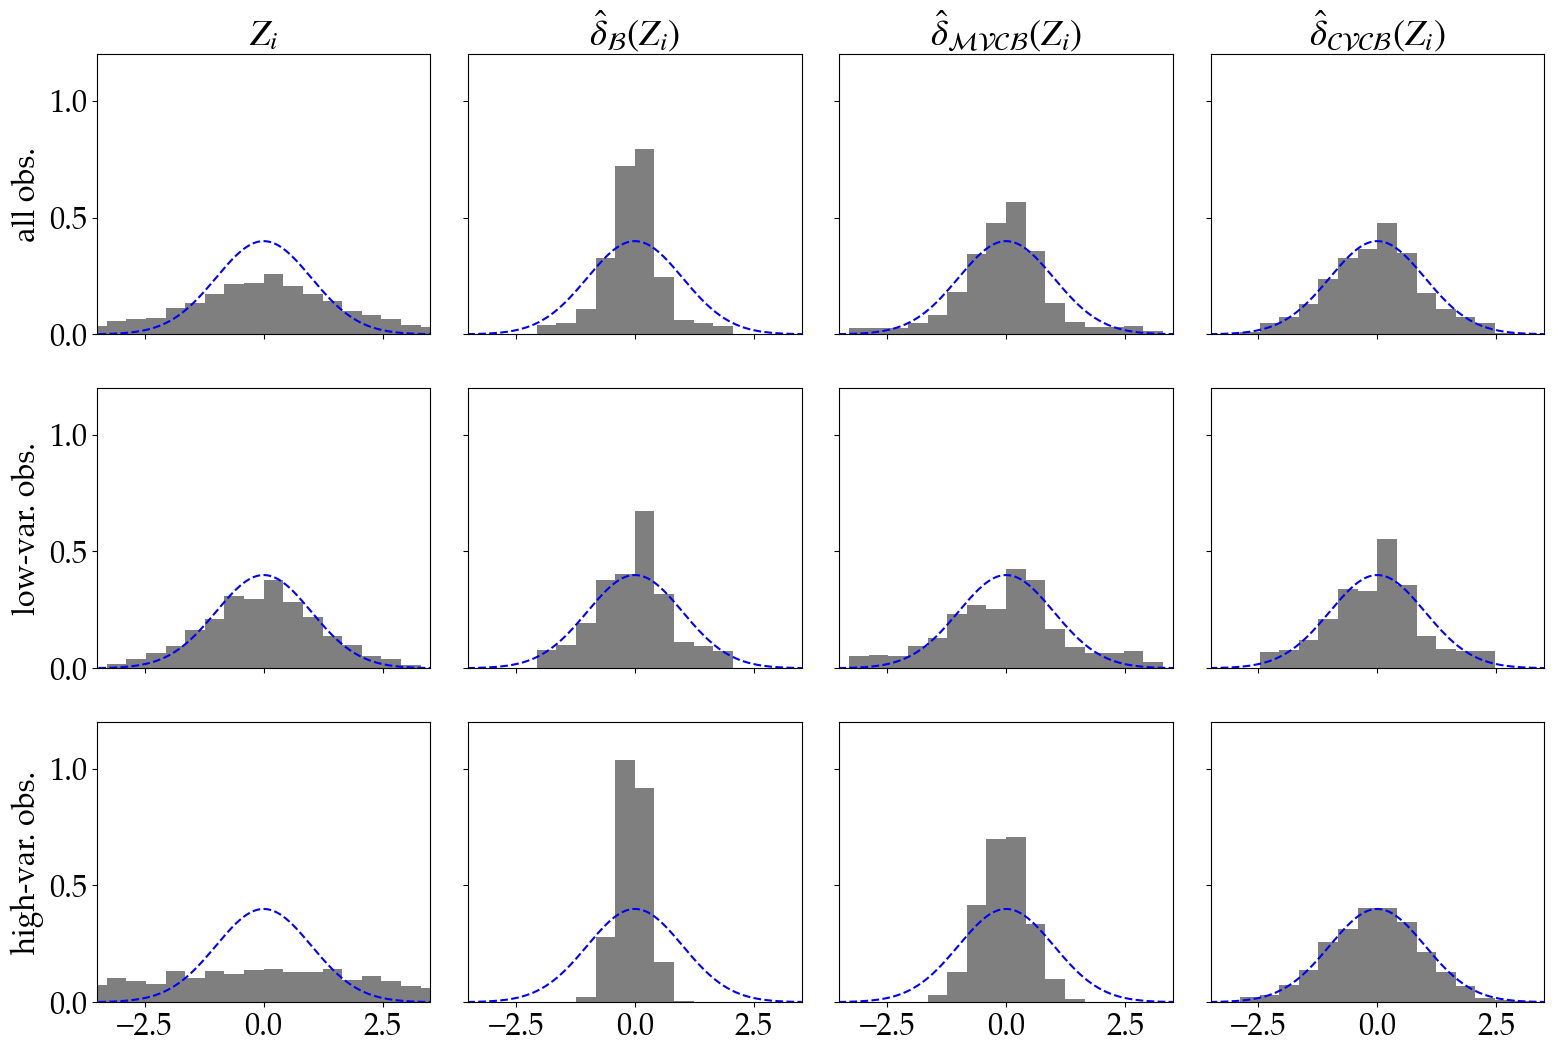

In [15]:
plt.rcParams.update({'font.size': 22,
                     'mathtext.fontset': 'stix',
                     'font.family': 'serif',
                     'font.serif':'Palatino'})

Z_alpha = 0.5
bins=np.linspace(-xlim,xlim,35)
fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(16,11))

ax[0,0].hist(Z, bins=bins, density=True, alpha=Z_alpha, color='black')
ax[0,0].set_ylabel('all obs.')
ax[0,1].hist(eb, bins=bins, density=True, alpha=Z_alpha, color='black')
ax[0,2].hist(eb_mcb, bins=bins, density=True, alpha=Z_alpha, color='black')
ax[0,3].hist(eb_ccb, bins=bins, density=True, alpha=Z_alpha, color='black')

ax[1,0].hist(Z[Sigma2==var1], bins=bins, density=True, alpha=Z_alpha, color='black')
ax[1,0].set_ylabel('low-var. obs.')
ax[1,1].hist(eb[Sigma2==var1], bins=bins, density=True, alpha=Z_alpha, color='black')
ax[1,2].hist(eb_mcb[Sigma2==var1], bins=bins, density=True, alpha=Z_alpha, color='black')
ax[1,3].hist(eb_ccb[Sigma2==var1], bins=bins, density=True, alpha=Z_alpha, color='black')

ax[2,0].hist(Z[Sigma2==var2], bins=bins, density=True, alpha=Z_alpha, color='black')
ax[2,0].set_ylabel('high-var. obs.')
ax[2,1].hist(eb[Sigma2==var2], bins=bins, density=True, alpha=Z_alpha, color='black')
ax[2,2].hist(eb_mcb[Sigma2==var2], bins=bins, density=True, alpha=Z_alpha, color='black')
ax[2,3].hist(eb_ccb[Sigma2==var2], bins=bins, density=True, alpha=Z_alpha, color='black')

ax[0,0].set_title('$Z_i$')
ax[0,1].set_title('$\\hat{\\delta}_{\\mathcal{B}}(Z_i)$')
ax[0,2].set_title('$\\hat{\\delta}_{\\mathcal{MVCB}}(Z_i)$')
ax[0,3].set_title('$\\hat{\\delta}_{\\mathcal{CVCB}}(Z_i)$')
ax[0,3].set_xlim([-xlim/2,xlim/2])
ax[0,3].set_ylim([0.,1.2])

rv = norm()
x = np.linspace(-xlim,xlim,num=500)
for i in [0,1,2]:
    for j in [0,1,2,3]:
        ax[i,j].plot(x, norm.pdf(x),color='blue', linestyle='dashed')

        
plt.tight_layout()
# plt.savefig('marginal_conditional.png')
# plt.savefig('marginal_conditional.pdf')
plt.show()